$\newcommand{\x}[1]{\textbf{x}_{#1}}$
$\newcommand{\alp}[1]{\alpha_{#1}}$
$\newcommand{\alphat}[1]{\bar{\alpha}_{#1}}$
$\newcommand{\sqrtalpha}[1]{\sqrt{\alpha_{#1}}}$
$\newcommand{\sqrtalphahat}[1]{\sqrt{\bar{\alpha}_{#1}}}$
$\newcommand{\xhat}[1]{\hat{\textbf{\textit{x}}}_{#1}}$
$\newcommand{\bmu}[1]{\mathbf{\mu}_{#1}}$
$\newcommand{\bSigma}[1]{\mathbf{\Sigma}_{#1}}$

In [6]:
from torch.utils.data import DataLoader, random_split
import torch

torch.manual_seed(42)

from utils import CelebA, CIFAR10

data = CelebA(n = 50_000, size=32)

split_fracs = [0.8, 0.15, 0.05]
train_set, test_set, val_set = random_split(data, split_fracs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

dimensions = train_set[0].shape
img_size = torch.prod(torch.tensor(dimensions))

Files already downloaded and verified
Device:  cuda:0


## The data
First, let's have a look at our data. Our data will conist of images and will therefore have the dimensions (channels, height, width).<br>
These pictures are our "ground-truth", and we'll denote them as $\mathbf{\textit{x}}_0$. <br>
It is these pictures that we gradually will make more and more noisy in order to train our model.

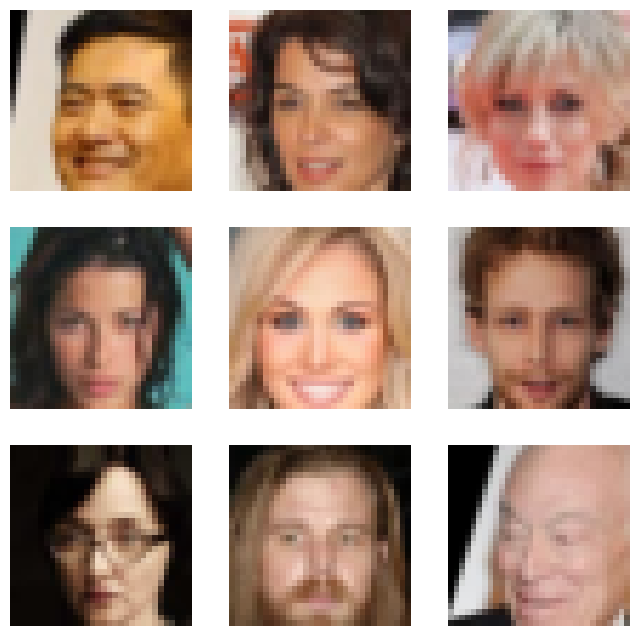

In [7]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a 
# grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set[i]
    img = img * 0.5 + 0.5
    axs[i//3, i%3].imshow(img.view(*dimensions).permute(1,2,0), cmap='gray')
    axs[i//3, i%3].axis('off')

plt.savefig('figures/celeba.png', dpi=300, bbox_inches='tight')
plt.show()

## Noise schedule
The noise schedule is defined as: <br>
$\begin{equation}
q(\x{t}|\x{t-1}) = \mathcal{N}(\x{t};\sqrt{1-\beta_t}\x{t-1},\beta_t \mathbf{I})
\end{equation}$
Where $\beta_t$ are linear interpolations on the range from $\beta_{0}$ to $\beta_{T}$. Typically, the noise schedule will be in the range from $\beta_0=0.001$ to $\beta_T = 0.02$. <br>
#### The noise schedule describes what distribution each pixel value should follow in the next noisy image based on the prior slightly less noisy image.<br>
If we let $\alpha_t$ = $1-\beta_t$, it can be shown that some arbitrary timestep, $t$, will follow this distribution: <br>
$\begin{equation}
 q(\x{t}|\x{0}) = \mathcal{N}(\x{t}, \sqrt{\bar{\alpha}_t}\x{0}, (1-\bar{\alpha}_t) \mathbf{I})
\end{equation}$
Where $\bar{\alpha}_t = \prod_{t=1}^T \alpha_t$.<br>
The Markov-chain also assures us that it doesnt matter whether we condition of $\x{0}$ or $\x{t-1}$, since $\x{t-1}$ only depends on $\x{0}$ anyways. <br>
Using the reparameteriation trick, a sample can be drawn by calculating:
$\begin{equation}
\x{t} = \sqrtalphahat{t}\x{0} +\sqrt{1-\alphat{t}}\epsilon^* \hspace{10mm} \epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})
\end{equation}$
#### Using this fact, we can take some $\x{0}$, randomly sample some timesteps, $t \in [1, T]$, find the pertaining distributions for the noisy images and draw a sample from this distribution:

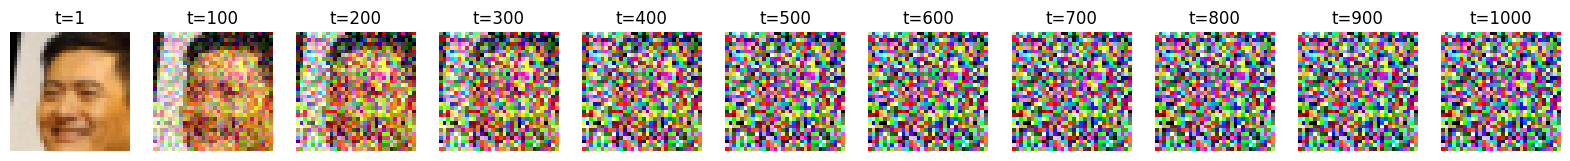

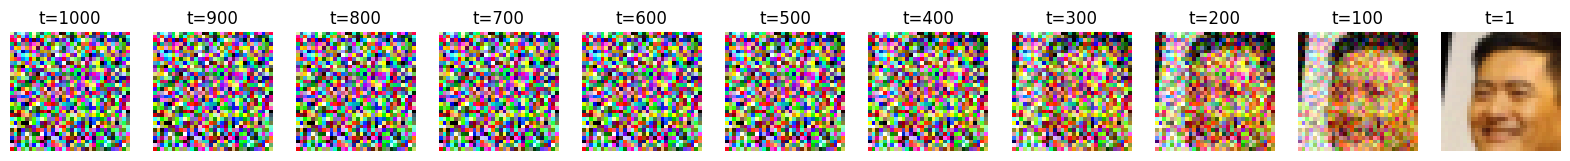

In [8]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 1000
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.savefig("figures/noisy_images.png", dpi=300, bbox_inches='tight')
plt.show()

## show the same process in reverse

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
for i, t in enumerate(reversed(ts)):
    img = xts[- i - 1].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')

plt.savefig("figures/noisy_images_reverse.png", dpi=300, bbox_inches='tight')
plt.show()




# Examining the distribution

A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel. <br>
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. <br>
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

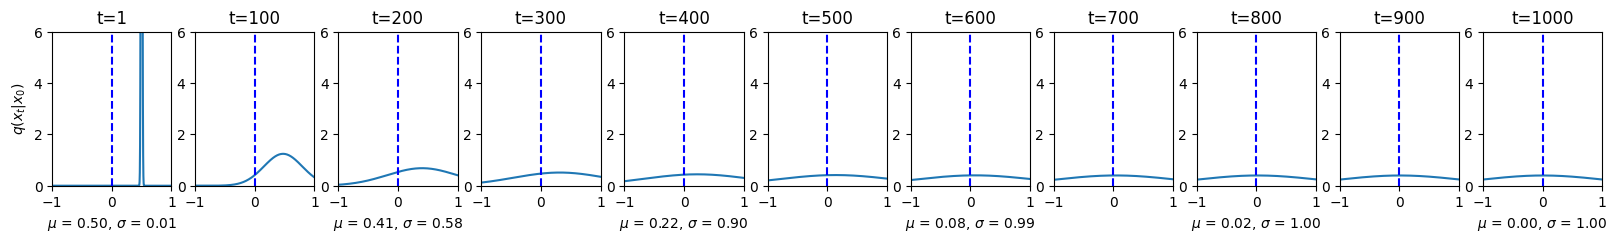

In [9]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('$q(x_t | x_0)$')

plt.savefig("figures/pixel_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# The distribution of $p(\x{T})$
To show that the distribution of the final layer ($p(\x{T})$) actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

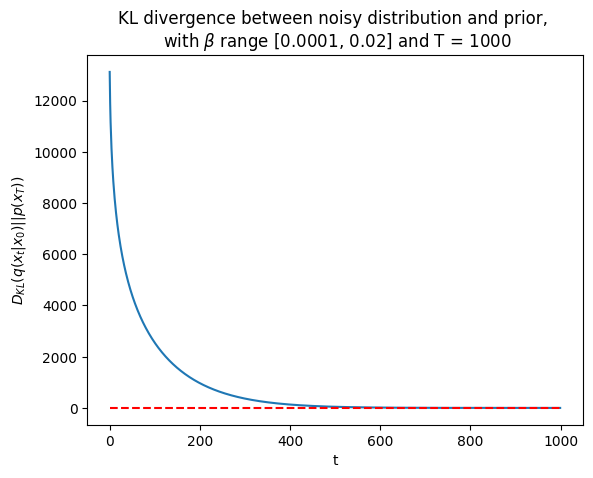

In [10]:
from tqdm import tqdm

## this small image is just a 10x10 patch of the original image

KL_list = np.zeros(T)
for t in range(T):
    mu = noise_schedule.sqrt_alpha_hat[t] * x0.flatten()
    std = noise_schedule.sqrt_one_minus_alpha_hat[t]

    k1 = img_size * std ** 2
    k2 = torch.sum(mu ** 2)
    k3 = - 2 * img_size * torch.log(std)
    kl = 1/2 * (k1 + k2 + k3 - img_size)
    
    KL_list[t] = kl.detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("$D_{KL}(q(x_t | x_0) || p(x_T))$")
plt.hlines(0, 0, T, color='r', linestyle='--')
plt.savefig("figures/KL_divergence.png", dpi=300, bbox_inches='tight')
plt.show()


## Encoding the timesteps
It can be shown, that in order to train a diffusion model, the following loss function can be used:
$\begin{equation}
\mathcal{L}_{simple} = ||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2
\end{equation}$
Where $\epsilon^*$ is the noise used to sample $\x{t}$ from $\x{0}$, and where $\hat{\epsilon}_{\theta}$ is our models best guess at this noise. <br>
Since we're making one model for all timesteps, it could be beneficial to somehow tell the model which timestep it is in (notice that $t$ is also an input to the model). There are different approaches to this: deterministic timeembeddings and learnable timeembeddings. <br>
We decided to go with deterministic, sinusoidal encoding. This means that every $t$ gets mapped to a unique $sin$ and $cos$ wave as visualized below using a heat map:

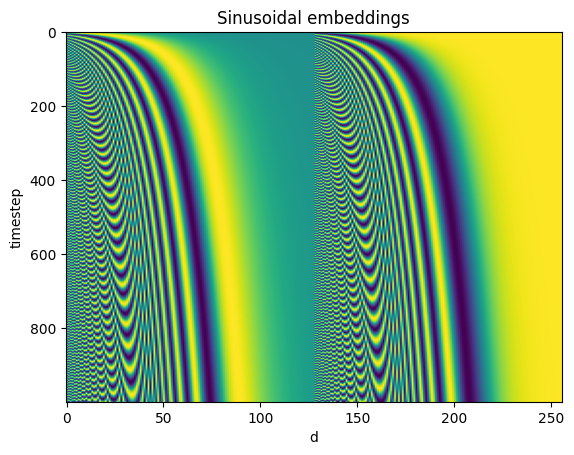

In [11]:
from utils import SinusoidalEmbeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings, cmap='viridis', aspect='auto')
plt.ylabel("timestep")
plt.xlabel("d")
plt.title("Sinusoidal embeddings")
plt.savefig("figures/sinusoidal_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()


## The model
The model is a simple residual UNet using convolutions. <br>
The simple loss, $\mathcal{L}_{simple}$, can be summarised as:
   
1. **Repeat until convergence:**
   - $\x{0} \sim q(\x{0})$
   - $t \sim \text{Uniform}(1,\dots,T)$
   - $\epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})$
   - $\x{t} \gets \sqrtalphahat{t}\x{0} + \sqrt{1-\alphat{t}}\epsilon^*$
   - Take a gradient descent step on $\nabla_{\theta}||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2$

The loss function can be found inside the model class.<br>
For now, we'll train very small models with few parameters since we want to examine the behaviour of the model later. <br>
Later on, we'll train a bigger model.

In [12]:
from utils import SimpleModel
from model import UNetModel

network_args = {
    "in_channels": dimensions[0], 
    "model_channels": 64, 
    "out_channels": dimensions[0], 
    "num_res_blocks": 1, 
    "attention_resolutions": [2], 
    "dropout": 0.1,
    "num_heads": 8,
    "num_heads_upsample": 8,
}

simple_network = UNetModel(**network_args)

model_args = [simple_network, noise_schedule, dimensions, device]
simple_model = SimpleModel(*model_args)
simple_model.load_model()
num_params = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)
print("Number of parameters: ", num_params)

Model loaded from ../models/simple_model.pt
Number of parameters:  39902147


## Visualizing performance
It could be a good idea to see how well our model is performing after each epoch. Of course, we'll look at the loss, but we'll also take a look at how well the model can sample new images.
The sample process can be described as:
1. **Initialize:**
   - $\x{T} \sim \mathcal{N}(\mathbf{0},\mathbf{1})$ 

2. **For $t$ from $T$ down to $1$ do the following:**
   - $\x{t-1} \gets \frac{1}{\sqrtalpha{t}}\x{t}-\frac{1-\alp{t}}{\sqrt{1-\alphat{t}}\sqrtalpha{t}}\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)$
   
   - **If $t > 0$:**
     - $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{1})$
     - $\x{t-1} \gets \x{t-1} + \mathbf{z}\sigma_q(t)$

3. **Return:**
   - $x_0$

The code for finding the prior sample (finding $\x{t-1}$ from $\x{t}$) can be found in the model class.



In [46]:
from utils import training_loop

In [19]:
simple_model_losses, simple_model_parameters = training_loop(simple_model, 20, train_set, val_set, batch_size=64, save_params=True)
torch.save(simple_model_parameters, "../data/simple_model_parameters.pt")
torch.save(simple_model_losses, "../data/simple_model_losses.pt")

100%|██████████| 625/625 [11:49<00:00,  1.14s/it]


Model saved to ../models/simple_model.pt
Epoch: 0
Train loss: 0.26865530014038086
Validation loss: 0.06535654295331393


100%|██████████| 625/625 [09:15<00:00,  1.12it/s]


Model saved to ../models/simple_model.pt
Epoch: 1
Train loss: 0.05284510925412178
Validation loss: 0.043326835697278


100%|██████████| 625/625 [09:27<00:00,  1.10it/s]


Model saved to ../models/simple_model.pt
Epoch: 2
Train loss: 0.04160747304558754
Validation loss: 0.03871201924406565


100%|██████████| 625/625 [10:03<00:00,  1.04it/s]


Model saved to ../models/simple_model.pt
Epoch: 3
Train loss: 0.03817475587129593
Validation loss: 0.03549107211904648


100%|██████████| 625/625 [10:12<00:00,  1.02it/s]


Model saved to ../models/simple_model.pt
Epoch: 4
Train loss: 0.03538858890533447
Validation loss: 0.035175605748708434


100%|██████████| 625/625 [10:25<00:00,  1.00s/it]


Model saved to ../models/simple_model.pt
Epoch: 5
Train loss: 0.03483400493860245
Validation loss: 0.03384090343920084


100%|██████████| 625/625 [10:27<00:00,  1.00s/it]


Model saved to ../models/simple_model.pt
Epoch: 6
Train loss: 0.03394637256860733
Validation loss: 0.03287074557290627


100%|██████████| 625/625 [10:05<00:00,  1.03it/s]


Model saved to ../models/simple_model.pt
Epoch: 7
Train loss: 0.03231002017855644
Validation loss: 0.03150497565571314


100%|██████████| 625/625 [10:10<00:00,  1.02it/s]


Model saved to ../models/simple_model.pt
Epoch: 8
Train loss: 0.03135251626372337
Validation loss: 0.032019197988586545


100%|██████████| 625/625 [10:17<00:00,  1.01it/s]


Model saved to ../models/simple_model.pt
Epoch: 9
Train loss: 0.031208300963044167
Validation loss: 0.03228723276884128


100%|██████████| 625/625 [10:04<00:00,  1.03it/s]


Model saved to ../models/simple_model.pt
Epoch: 10
Train loss: 0.031069546937942505
Validation loss: 0.029864259828359652


100%|██████████| 625/625 [09:38<00:00,  1.08it/s]


Model saved to ../models/simple_model.pt
Epoch: 11
Train loss: 0.030512720346450806
Validation loss: 0.030175394880083892


100%|██████████| 625/625 [09:42<00:00,  1.07it/s]


Model saved to ../models/simple_model.pt
Epoch: 12
Train loss: 0.02938094735145569
Validation loss: 0.030299288149063405


100%|██████████| 625/625 [09:39<00:00,  1.08it/s]


Model saved to ../models/simple_model.pt
Epoch: 13
Train loss: 0.028942352160811424
Validation loss: 0.028374230441374656


100%|██████████| 625/625 [09:40<00:00,  1.08it/s]


Model saved to ../models/simple_model.pt
Epoch: 14
Train loss: 0.029033780097961426
Validation loss: 0.028092681812361266


100%|██████████| 625/625 [09:34<00:00,  1.09it/s]


Model saved to ../models/simple_model.pt
Epoch: 15
Train loss: 0.029179872944951057
Validation loss: 0.028036477497945994


100%|██████████| 625/625 [10:29<00:00,  1.01s/it]


Model saved to ../models/simple_model.pt
Epoch: 16
Train loss: 0.028805529698729515
Validation loss: 0.026600906911950845


100%|██████████| 625/625 [10:26<00:00,  1.00s/it]


Model saved to ../models/simple_model.pt
Epoch: 17
Train loss: 0.028293685987591743
Validation loss: 0.027968191756651953


100%|██████████| 625/625 [10:24<00:00,  1.00it/s]


Model saved to ../models/simple_model.pt
Epoch: 18
Train loss: 0.028083840385079384
Validation loss: 0.02825142498104236


100%|██████████| 625/625 [11:20<00:00,  1.09s/it]


Model saved to ../models/simple_model.pt
Epoch: 19
Train loss: 0.028177591040730476
Validation loss: 0.027960400694073774


After training is done, we can also calculate how well the model performs on the testset.
We'll visualize this test loss in a plot later.

In [22]:
from utils import test_model
simple_model_test_loss = test_model(simple_model, test_set, batch_size=64)

In [48]:
from utils import sample_approved_grid, sample_grid, sample_intermediate_images, show_losses

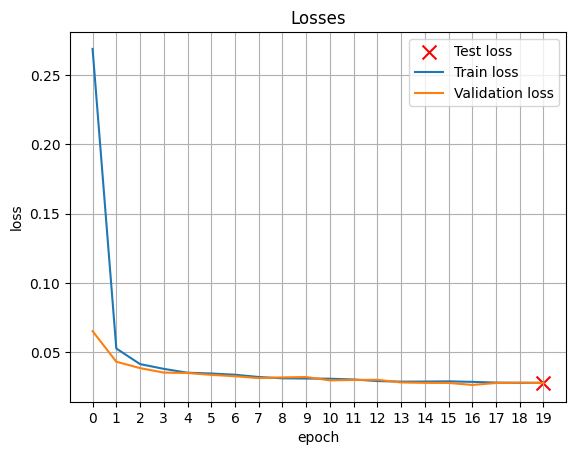

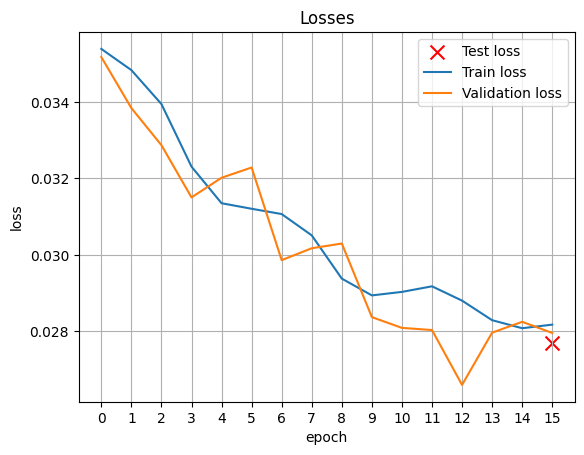

In [23]:
show_losses(simple_model_losses, simple_model_test_loss)
show_losses(simple_model_losses[4:], simple_model_test_loss)

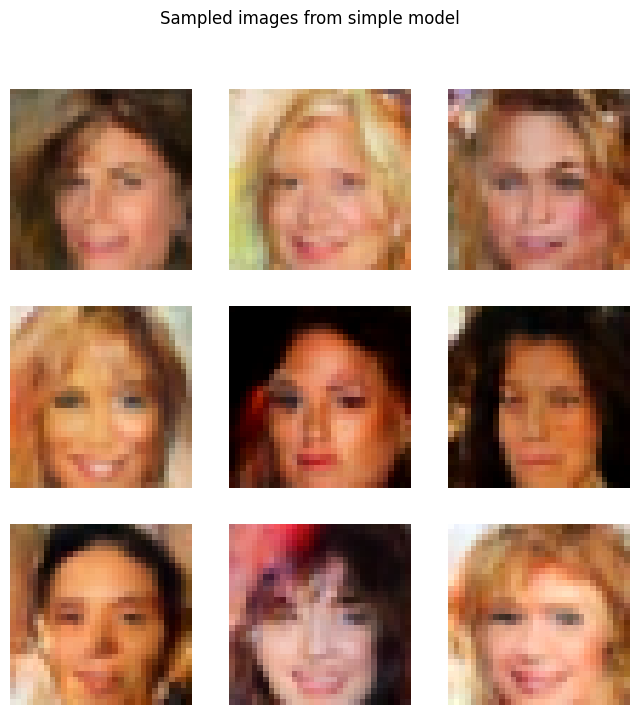

In [24]:
sample_approved_grid(simple_model, title="Sampled images from simple model")

Sampling image..


1000it [00:17, 55.80it/s]                        


Done sampling image


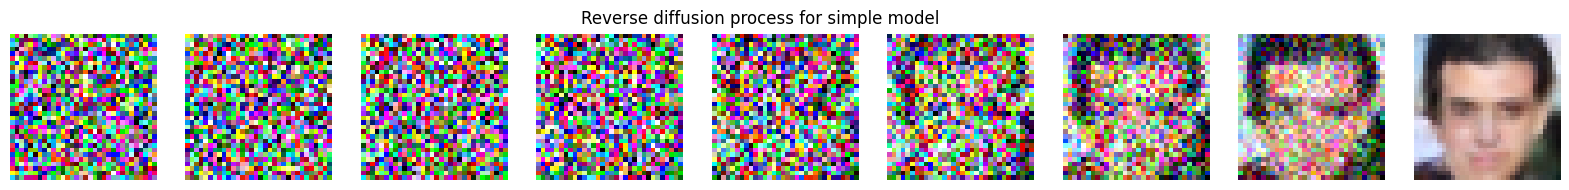

In [49]:
sample_intermediate_images(simple_model, title="Reverse diffusion process for simple model")

## Another type of model
We will repeat the above, but for another type of loss function. 
This loss function doesnt predict the noise, $\epsilon^*$, but rather the original image, $\x{0}$. <br>
We wont go into too many details around how this model works, but we'll later try to compare the performance of the different models.

In [50]:
from utils import x0Model

torch.cuda.empty_cache()

x0_network = UNetModel(**network_args)

model_args = [x0_network, noise_schedule, dimensions, device]
x0_model = x0Model(*model_args)
x0_model.load_model()

Failed to load model from ../models/x0_model.pt
Initializing new model


In [52]:
x0_model_losses, x0_model_parameters = training_loop(x0_model, 20, train_set, val_set, batch_size=64, save_params=True)
torch.save(x0_model_parameters, "../data/x0_model_parameters.pt")
torch.save(x0_model_losses, "../data/x0_model_losses.pt")

100%|██████████| 625/625 [10:31<00:00,  1.01s/it]


Model saved to ../models/x0_model.pt
Epoch: 0
Train loss: 0.15293297171592712
Validation loss: 0.11354534499920331


100%|██████████| 625/625 [09:27<00:00,  1.10it/s]


Model saved to ../models/x0_model.pt
Epoch: 1
Train loss: 0.11031177639961243
Validation loss: 0.10593939610780814


100%|██████████| 625/625 [09:23<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 2
Train loss: 0.10559286177158356
Validation loss: 0.10234539420940937


100%|██████████| 625/625 [09:24<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 3
Train loss: 0.10287363082170486
Validation loss: 0.10334070982077183


100%|██████████| 625/625 [09:25<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 4
Train loss: 0.10186341404914856
Validation loss: 0.10298094229820447


100%|██████████| 625/625 [09:25<00:00,  1.10it/s]


Model saved to ../models/x0_model.pt
Epoch: 5
Train loss: 0.10067068040370941
Validation loss: 0.102877527093276


100%|██████████| 625/625 [09:25<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 6
Train loss: 0.10049828141927719
Validation loss: 0.10064805356355813


100%|██████████| 625/625 [09:21<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 7
Train loss: 0.1008504182100296
Validation loss: 0.10079543999372384


100%|██████████| 625/625 [09:25<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 8
Train loss: 0.10014069080352783
Validation loss: 0.10009754105256154


100%|██████████| 625/625 [09:21<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 9
Train loss: 0.09983384609222412
Validation loss: 0.0994519604704319


100%|██████████| 625/625 [09:25<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 10
Train loss: 0.09905733913183212
Validation loss: 0.10002450702282098


100%|██████████| 625/625 [09:23<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 11
Train loss: 0.09836427867412567
Validation loss: 0.09943061532118382


100%|██████████| 625/625 [09:21<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 12
Train loss: 0.0989564061164856
Validation loss: 0.09941131965472148


100%|██████████| 625/625 [09:24<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 13
Train loss: 0.09925668686628342
Validation loss: 0.09717837300820228


100%|██████████| 625/625 [09:22<00:00,  1.11it/s]


Model saved to ../models/x0_model.pt
Epoch: 14
Train loss: 0.09842555224895477
Validation loss: 0.09810213840160614


100%|██████████| 625/625 [09:27<00:00,  1.10it/s]


Model saved to ../models/x0_model.pt
Epoch: 15
Train loss: 0.09848099201917648
Validation loss: 0.09309471608736576


100%|██████████| 625/625 [09:54<00:00,  1.05it/s]


Model saved to ../models/x0_model.pt
Epoch: 16
Train loss: 0.09782297164201736
Validation loss: 0.09728129303608185


100%|██████████| 625/625 [09:59<00:00,  1.04it/s]


Model saved to ../models/x0_model.pt
Epoch: 17
Train loss: 0.09746074676513672
Validation loss: 0.09864812669081566


100%|██████████| 625/625 [09:44<00:00,  1.07it/s]


Model saved to ../models/x0_model.pt
Epoch: 18
Train loss: 0.09794600307941437
Validation loss: 0.0985780486311668


100%|██████████| 625/625 [09:36<00:00,  1.08it/s]


Model saved to ../models/x0_model.pt
Epoch: 19
Train loss: 0.09805438667535782
Validation loss: 0.09475567726752697


In [55]:
from utils import test_model
x0_model_test_loss = test_model(x0_model, test_set, batch_size=64)

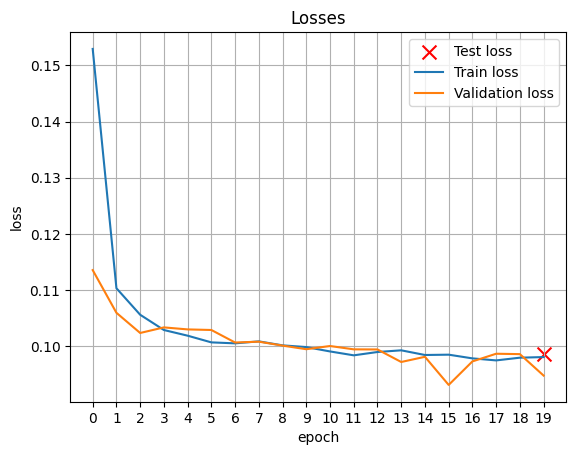

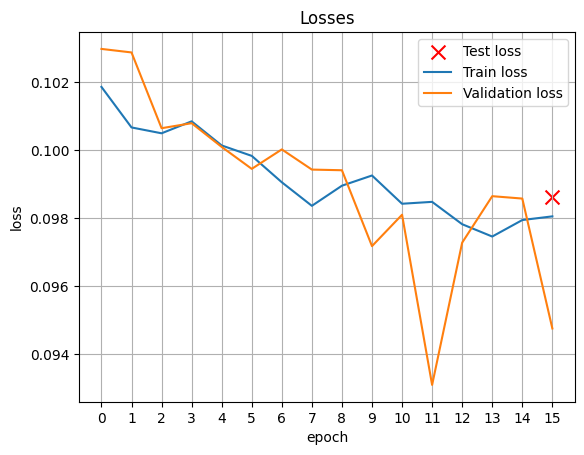

In [56]:
show_losses(x0_model_losses, x0_model_test_loss)
show_losses(x0_model_losses[4:], x0_model_test_loss)

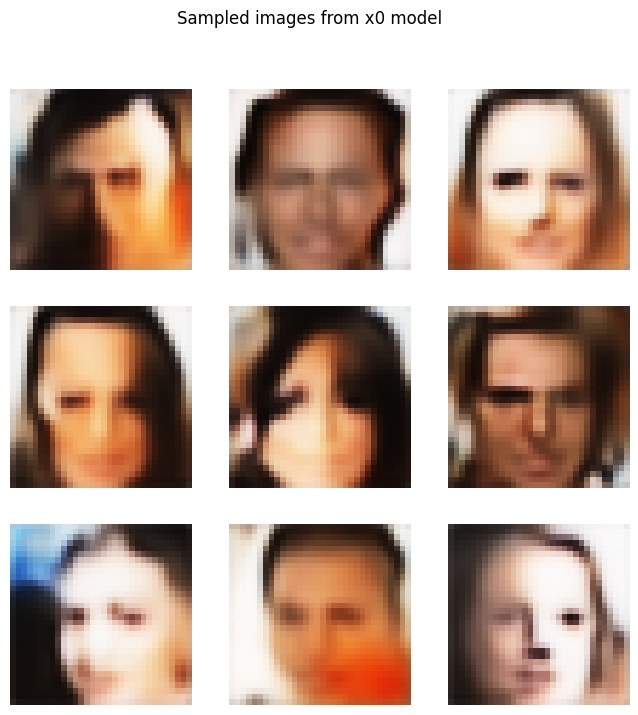

In [57]:
sample_approved_grid(x0_model, title="Sampled images from x0 model")

Sampling image..


1000it [00:18, 52.63it/s]                        


Done sampling image


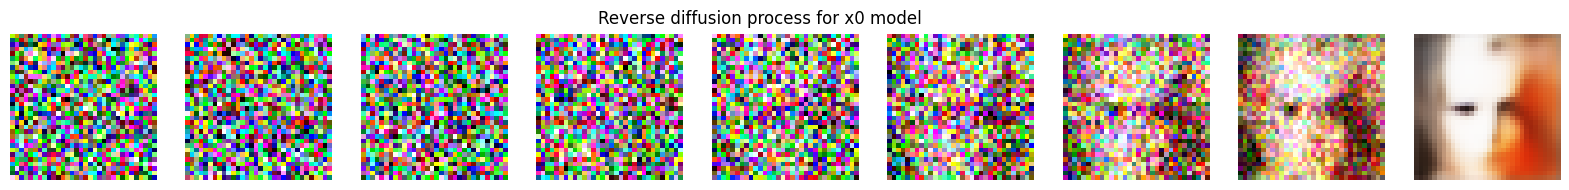

In [58]:
sample_intermediate_images(x0_model, title="Reverse diffusion process for x0 model")

In [ ]:
def error_per_timestep(model, dataset):
    n = 1
    model.eval()
    x0s = dataset[:n]
    ls = np.zeros(T)

    for i, t in tqdm(enumerate(range(T)), total=T):
        with torch.no_grad():
            l = model.loss(x0s.view(n, *dimensions), torch.tensor([t]).long().repeat(n, 1))
            ls[i] = l.item()

    return ls

In [ ]:
simple_model_errors = error_per_timestep(simple_model, test_set)[1:]
simple_model_objective = 1 / (2 * noise_schedule.sigma_sq[1:]) * (1 - noise_schedule.alpha[1:]) ** 2 / (noise_schedule.one_minus_alpha_hat[1:] * noise_schedule.alpha[1:]) * simple_model_errors

plt.plot(simple_model_objective)
plt.xlabel("t")
plt.ylabel("Objective_t")
plt.title(f"Objective = {simple_model_objective.sum().item():.2f} (Simple model)")

In [ ]:
x0_model_errors = error_per_timestep(x0_model, test_set)[1:]
x0_model_objective = 1 / (2 * noise_schedule.sigma_sq[1:]) * torch.roll(noise_schedule.alpha_hat, 1)[1:] * (1 - noise_schedule.alpha[1:]) ** 2 / noise_schedule.one_minus_alpha_hat[1:]**2 * x0_model_errors

plt.plot(x0_model_objective)
plt.xlabel("t")
plt.ylabel("Objective_t")
plt.title(f"Objective = {x0_model_objective.sum().item():.2f} (x0 model)")

In [13]:
def make_state_dict_from_paramters(model, parameters):
    state_dict = model.state_dict()
    start = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            end = start + param.numel()
            state_dict[name] = parameters[start:end].view(param.shape).to(device)
            start = end
    return state_dict

In [14]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler


def make_loss_landscape(parameters, resolution = 30):
    best_params = parameters[-1]

    num_params = parameters.shape[1]
    len_subset = int(0.2 * num_params)
    indxs = np.random.choice(num_params, len_subset, replace=False)
    subset_params = parameters[:, indxs]
    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=2)

    normalized_parameters = scaler.fit_transform(subset_params)

    print("Fitting PCA...")
    projections = pca.fit_transform(normalized_parameters)
    print("Done!")

    projections_std = projections.std(axis=0)

    x_start, x_end = projections[-1][0] - 60 * projections_std[0], projections[-1][0] + 60 * projections_std[0]
    y_start, y_end = projections[-1][1] - 60 * projections_std[1], projections[-1][1] + 60 * projections_std[1]

    x = np.linspace(x_start, x_end, resolution)
    y = np.linspace(y_start, y_end, resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    network_args = {
    "in_channels": dimensions[0], 
    "model_channels": 64, 
    "out_channels": dimensions[0], 
    "num_res_blocks": 1, 
    "attention_resolutions": [2], 
    "dropout": 0.1,
    "num_heads": 8,
    "num_heads_upsample": 8,
    }

    noise_schedule = NoiseSchedule(1e-4, 0.02, 1000)
    network = UNetModel(**network_args)
    model_args = [network, noise_schedule, dimensions, device]
    model = SimpleModel(*model_args)

    print("Calculating loss landscape...")
    for i, x_i in tqdm(enumerate(x), total=resolution):
        for j, y_j in enumerate(y):
            new_params_subset = scaler.inverse_transform(pca.inverse_transform([[x_i, y_j]]))
            best_params[indxs] = new_params_subset
            state_dict = make_state_dict_from_paramters(simple_model, torch.from_numpy(best_params))
            model.load_state_dict(state_dict)
            Z[i, j] = model.loss(test_set[0].view(1, *dimensions)).item()
    
    print("Done!")

    return X, Y, Z

def plot_loss_landscape(X, Y, Z, title="Loss landscape", angle=30):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zlabel("Loss")
    ax.view_init(30, angle)
    plt.savefig(f"figures/{title}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_contour(X, Y, Z, title="Loss landscape"):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.contourf(X, Y, Z, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

Fitting PCA...
Done!
Calculating loss landscape...


100%|██████████| 30/30 [07:25<00:00, 14.86s/it]


Done!


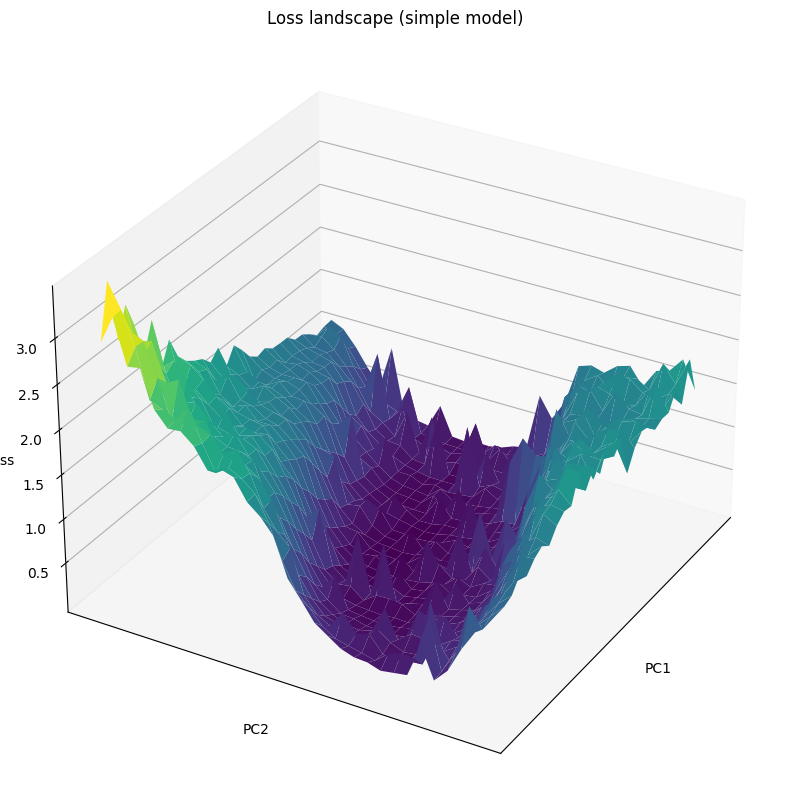

In [15]:
simple_model_parameters = torch.load("../data/simple_model_parameters.pt").detach().numpy()
X, Y, Z = make_loss_landscape(simple_model_parameters, resolution=30)
plot_loss_landscape(X, Y, Z, title="Loss landscape (simple model)")

Fitting PCA...
Done!
Calculating loss landscape...


100%|██████████| 30/30 [07:29<00:00, 14.99s/it]


Done!


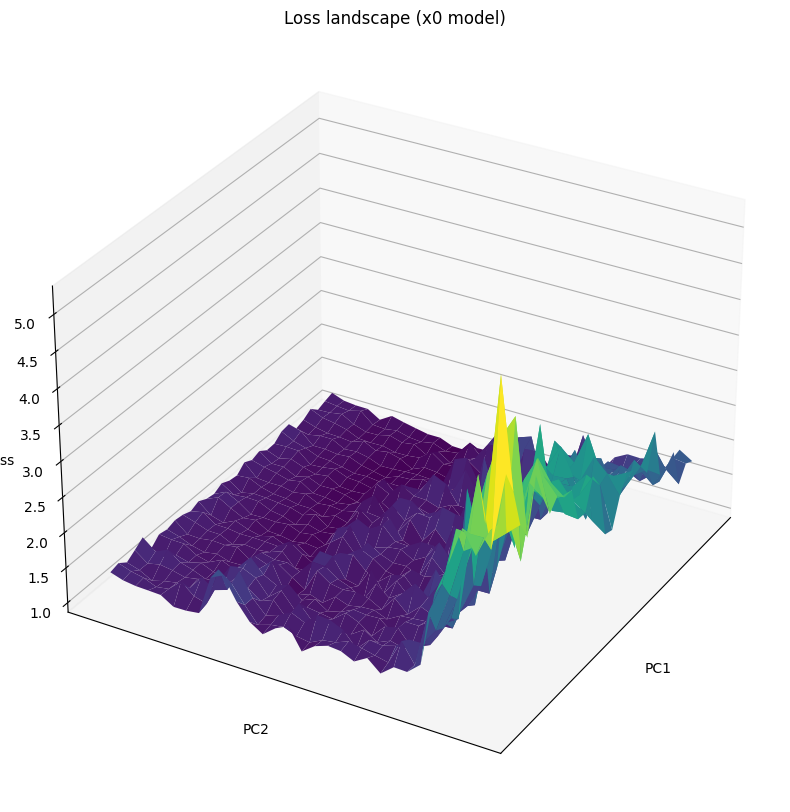

In [17]:
x0_model_parameters = torch.load("../data/x0_model_parameters.pt").detach().numpy()
X, Y, Z = make_loss_landscape(x0_model_parameters, resolution=30)
plot_loss_landscape(X, Y, Z, title="Loss landscape (x0 model)")